# Getting the data

## Step 1: Import Libraries
We'll use the following libraries in this notebook:

In [6]:
import pandas as pd
from datetime import datetime, timedelta, time
import numpy as np
from scipy.ndimage.interpolation import shift
from collections import defaultdict
import seaborn as sns
import sys

%matplotlib inline

In [11]:
print("Python Version:", sys.version)
print("Pandas Version:", pd.__version__)
print("Numpy Version:", np.__version__)
print("Seaborn Version:", sns.__version__)
collections.__v

Python Version: 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas Version: 0.20.3
Numpy Version: 1.13.3
Seaborn Version: 0.8.0


## Step 2: Getting the right data 
We pulled in weekly turnstile data from the MTA portal: http://web.mta.info/developers/turnstile.html

First, we create a list of the weeks we're interested in fetching data for

In [8]:
# Define list of weeks we want to pull from the MTA portal

def datelist(startdate):
    """
    For a given Saturday, make a list of dates for the 14 previous Saturdays
    """
    week_list = [startdate + ((timedelta(days=-7))*i) for i in range(14)]
    clean_weeks = [i.strftime('%y%m%d') for i in week_list]
    return clean_weeks


# Define the last Saturday we're interested in for 2016 and 2017
start17 = datetime(2017, 7, 1)
start16 = datetime(2016, 7, 2)

# We'll import data for the 14 weeks preceeding July 1st for both 2016 and 2017
weeks_to_import = datelist(start17) + datelist(start16)

We then iterate through our list of dates to pull weekly files from the MTA portal

In [11]:
def loadturndata(date):
    # Build the filename
    strdate = str(date)
    filename = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'+strdate+'.txt'

    # Read in the csv
    df = pd.read_csv(filename)
    return df


def loadturnlist(dates):
    """
    We'll iterarte through the list of weeks to create dataframes using loadturndata and then concat together into one dataframe 
    """
    data = pd.DataFrame()
    x = []
    for i in dates:
        df = (loadturndata(i))
        x.append(df)
    data = pd.concat(x)
    return data

In [17]:
# Note: This takes a few minutes to run - go treat yourself to a cup of tea!
raw = loadturnlist(weeks_to_import)

In [37]:
# Pickle the raw data in case things go south in the cleaning process and you need to start over from here
raw.to_pickle('data/raw_turnstile_data.pkl')

# Cleaning the data
All the fun stuff (jk!)

## Rename columns and add datetime columns

In [3]:
# Uncomment below to read in the pickled raw data if you are starting here
#raw = pd.read_pickle('raw_turnstile_data.pkl')

In [4]:
# Rename columns
df = raw.rename(columns=lambda x: x.strip().lower())

# Concat date and time and convert to datetime object
df['datetime'] = df['date'] + ' ' + df['time']
df['datetime_clean'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in df['datetime']]

In [5]:
# Add some helpful date-part columns
df['year'] = [x.year for x in df['datetime_clean']]
df['weekday'] = df[['datetime_clean']].apply(lambda x: datetime.strftime(x['datetime_clean'], '%A'), axis=1)

## Find delta counts for distinct turnstiles at given time intervals

In [6]:
# Create group ID for distinct turnstiles
df['group'] = df['c/a'].astype(str) + \
                df['unit'].astype(str) + \
                df['scp'].astype(str) + \
                df['station'].astype(str)  + \
                df['linename'].astype(str) + \
                df['division'].astype(str) + \
                df['year'].astype(str)
                
# Map 'group' string to integer id     
groups = set(df['group'])


def groups_dict(groups):
    group_dict = defaultdict(int)
    for i in enumerate(list(groups)):
        group_dict[i[1]]= i[0]

    return group_dict

group_id_dict = groups_dict(groups)

df['group_id'] = [group_id_dict[x] for x in df['group']]

Create station ID for later grouping on distinct stations

In [7]:
# Create station ID for distinct stations
df['station_id'] = df['station'].astype(str) + \
                df['linename'].astype(str) + \
                df['division'].astype(str)

Sort values in dataframe by group id and datatime to find diff in counts from prev row

In [8]:
# Sort values by group id and date to find diff in turnstile counts from prev row
df.sort_values(['group_id','datetime_clean'], inplace=True)
df.reset_index(drop=True)

def find_diff_prev_row(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    col_diff = abs(col_array - col_array_shifted)

    return col_diff


df['entries_diff'] = find_diff_prev_row(df['entries'])
df['exit_diff'] = find_diff_prev_row(df['exits'])

Set invalid diff values to nan (first row of turnstile partitions and negative values from reboots)

In [9]:
# Identify first rows for each group partition to use as mask when setting invalid values to nan
def find_first_rows_groups(df_series_col):
    col_array = np.array(df_series_col)
    col_array_shifted = shift(col_array, 1, cval=np.NaN)
    first_row_mask = col_array != col_array_shifted

    return first_row_mask


df['first_row_group'] = find_first_rows_groups(df['group_id'])

# Make entries_diff and exit_diff nan when first row in group or negative value
df.loc[df['first_row_group'], 'entries_diff'] = None
df.loc[df['entries_diff'] < 0, 'entries_diff'] = None

df.loc[df['first_row_group'], 'exit_diff'] = None
df.loc[df['exit_diff'] < 0, 'exit_diff'] = None

## Deal with outliers and missing values

We'll call the describe method to check out the distribution of data for the entry and exit diffs calculated above

In [10]:
df.describe()

,entries,exits,year,group_id,entries_diff,exit_diff
count,5.481151e+06,5.481151e+06,5.481151e+06,5.481151e+06,5.471787e+06,5.471787e+06
mean,3.668874e+07,2.942573e+07,2.016504e+03,4.682275e+03,1.098745e+04,1.020665e+04
std,1.995975e+08,1.789708e+08,4.999825e-01,2.703455e+03,3.712465e+06,3.654583e+06
min,0.000000e+00,0.000000e+00,2.016000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.403665e+05,2.665350e+05,2.016000e+03,2.343000e+03,1.100000e+01,9.000000e+00
50%,2.597810e+06,1.490638e+06,2.017000e+03,4.682000e+03,8.200000e+01,5.500000e+01
75%,6.628317e+06,4.688856e+06,2.017000e+03,7.028000e+03,2.580000e+02,1.730000e+02
max,2.147483e+09,2.097170e+09,2.017000e+03,9.363000e+03,2.130766e+09,2.097170e+09


### Outliers
Outliers are commonly defined as values that fall above 1.5 IQR from the 75th Q. If we use this definition, ~13% of our values would qualify as outliers

In [11]:
def find_outliers(df_series, multiple_IQR):
    """
    For a series of numerical values, remove the zeros and identify the upper outliers 
    to return a mask for all outliers in series
    """
    non_zeros = df_series.replace(0, None)
    adjusted_IQR = (non_zeros.quantile(.75) - non_zeros.quantile(.25)) * multiple_IQR
    outlier_lim = non_zeros.quantile(.75) + adjusted_IQR
    print(outlier_lim)
    
    outliers = [True if x > outlier_lim else False for x in df_series]
    
    outlier_count = sum(outliers)
    all_data_count = len(df_series)
    print('{} outliers identified: {} of all data'.format(outlier_count, round(outlier_count/all_data_count,6)))
    
    return outliers

In [12]:
print('Entries Outliers')
df['entries_outlier'] = find_outliers(df['entries_diff'], 5)

print('Exit Outliers')
df['exit_outlier'] = find_outliers(df['exit_diff'], 5)

Entries Outliers
1564.0
21642 outliers identified: 0.003948 of all data
Exit Outliers
1041.0
69320 outliers identified: 0.012647 of all data


In [13]:
print('All Data Len:', len(df))

clean_df = df.loc[(~df['entries_outlier'] & ~df['exit_outlier'])].copy()
print('Excluding Outliers Len:', len(clean_df))

print('Keeping', round(len(clean_df)/len(df), 6))

All Data Len: 5481151
Excluding Outliers Len: 5391701
Keeping 0.98368


### Missing Values
We've decided to remove null values from our dataset

In [14]:
print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 9364
Null exit diffs 9364
Clean Data len: 5391701


In [15]:
clean_df.dropna(subset = ['entries_diff', 'exit_diff'], how='any', inplace=True)

print('Null entry diffs', clean_df.entries_diff.isnull().sum())
print('Null exit diffs', clean_df.exit_diff.isnull().sum())
print('Clean Data len:', len(clean_df))

Null entry diffs 0
Null exit diffs 0
Clean Data len: 5382337


In [16]:
thrown_away = len(df) - len(clean_df)
print("We're throwing away {} data points - about {} of the total".format(thrown_away, round(thrown_away/len(df), 4)))

We're throwing away 98814 data points - about 0.018 of the total


# Explore the distributions

## Find average weekly volume by station
But first we'll add some handy dimensions to group on

In [17]:
# Get count of all entries and exits
clean_df['all_traffic'] = clean_df['entries_diff'] + clean_df['exit_diff']

# Create dataframe with week value for 
clean_df['week'] = [x.isocalendar()[1] for x in clean_df['datetime_clean']]
clean_df['hour'] = [x.hour for x in clean_df['datetime_clean']]

Now we can find weekly average traffic for each station

In [18]:
# Find weekly average entry/exits per station
stations_week = clean_df.groupby(['station_id', 'week']).sum()
stations_week.reset_index(inplace=True)

weekly_avg = stations_week.groupby('station_id')['all_traffic'].mean()
weekly_avg.sort_values(ascending=False, inplace=True)

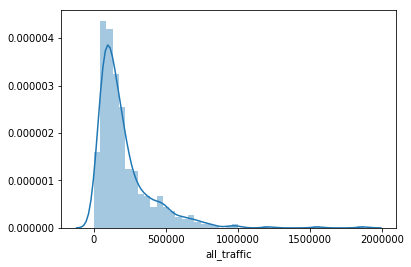

In [19]:
sns.distplot(weekly_avg, hist=True, kde=True);

In [20]:
weekly_avg.head(10)

station_id
GRD CNTRL-42 ST4567SIRT         1.871169e+06
34 ST-PENN STAACEIND            1.552853e+06
FLUSHING-MAIN7IRT               1.211654e+06
59 ST COLUMBUSABCD1IND          9.999501e+05
TIMES SQ-42 ST1237ACENQRSIRT    9.699950e+05
JKSN HT-ROOSVLTEFMR7IND         9.296883e+05
86 ST456IRT                     8.331130e+05
72 ST123IRT                     8.230710e+05
96 ST123IRT                     7.857210e+05
47-50 STS ROCKBDFMIND           7.794945e+05
Name: all_traffic, dtype: float64

Picked the cleaned turnstile dataset for joining with station data! 

In [21]:
clean_df.to_pickle('data/cleaned_turnstile_data.pkl')